In [1]:
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

from HistoricalData import HistoricalData
from OrderStatus import OrderStatus
from Backtest import Backtest
from SMAStrategy import SMAStrategy

import matplotlib.pyplot as plt 
import mplfinance as fplt
import matplotlib.dates as mpl_dates

import pandas as pd
import numpy as np
import pandas_ta as ta



In [2]:
def saveDataToCSV(symbol,timeframe='5m',higher_timeframe='30m',start_str='1 year ago UTC'):
    timeframe_pastData = HistoricalData.getHistoricalData('BINANCE',symbol,interval=timeframe,
                                                         start_str=start_str)
    
    path1 = './data/SMA/'+symbol+'_'+timeframe+'.csv'
    print("Saving Data to "+path1)
    
    timeframe_pastData.to_csv(path1,index=False)
    
    highertimeframe_pastData = HistoricalData.getHistoricalData('BINANCE',symbol,interval=higher_timeframe,
                                                         start_str=start_str)
    
    path2 = './data/SMA/'+symbol+'_'+higher_timeframe+'.csv'
    print("Saving Data to "+path2)
    
    highertimeframe_pastData.to_csv(path2,index=False)

In [3]:
symbol = 'BTCUSDT'

timeframe='5m'
higher_timeframe='30m'

lower_sma_interval = 22
higher_sma_interval = 55

sma_macd_interval = 13

atr_len = 10
filter_ma_interval = 200

path1 = './data/SMA/'+symbol+'_'+timeframe+'.csv'
path2 = './data/SMA/'+symbol+'_'+higher_timeframe+'.csv'
# saveDataToCSV(symbol)

In [4]:
dataframe_low = pd.read_csv(path1)
dataframe_high = pd.read_csv(path2)

In [5]:
dataframe_low.head(1)

,timestamp,open,high,low,close,volume,close_time,asset_volume,trades,buy_base_asset_volume,buy_quote_asset_volume,ignore
0,2020-01-03 14:50:00,7264.51,7271.87,7260.0,7261.55,96.949582,1578063299999,704328.630411,1057,50.211959,364805.127418,0


In [6]:
dataframe_high.tail(1)

,timestamp,open,high,low,close,volume,close_time,asset_volume,trades,buy_base_asset_volume,buy_quote_asset_volume,ignore
17527,2021-01-03 14:30:00,33927.0,34078.53,33700.0,33700.01,1695.367024,1609685999999,5.743644e+07,36298,775.499748,2.628022e+07,0


In [7]:
startTimeStamp = dataframe_high.head(1).timestamp.item()
endTimeStamp = dataframe_high.tail(1).timestamp.item()

In [8]:
dataframe_low = dataframe_low[(dataframe_low.timestamp>=startTimeStamp) 
                              & (endTimeStamp>=dataframe_low.timestamp)]
dataframe_low = dataframe_low.reset_index(drop=True)

In [9]:
dataframe_low['SMA_Low'] = ta.sma(dataframe_low.close,length=lower_sma_interval)
dataframe_low['SMA_High'] = ta.sma(dataframe_low.close,length=higher_sma_interval)

ohlc_dataframe_low = ta.ohlc4(dataframe_low.open,dataframe_low.high,
                             dataframe_low.low,dataframe_low.close)

dataframe_low['MACD_EMA_Low'] = ta.ema(ohlc_dataframe_low,length=lower_sma_interval)
dataframe_low['MACD_EMA_High'] = ta.ema(ohlc_dataframe_low,length=higher_sma_interval)

dataframe_low['MACD'] = dataframe_low['MACD_EMA_High'] - dataframe_low['MACD_EMA_Low']

dataframe_low['MACD_Signal'] = ta.sma(dataframe_low.MACD,length=sma_macd_interval)

dataframe_low['EMA'] = ta.ema(ohlc_dataframe_low,length=filter_ma_interval)
dataframe_low['ATR'] = ta.atr(dataframe_low.high, dataframe_low.low, dataframe_low.close, length=atr_len)
dataframe_low['EMA_Dev'] = dataframe_low.EMA.rolling(22).std()

dataframe_low = dataframe_low.dropna().reset_index(drop=True)



dataframe_low

,timestamp,open,high,low,close,volume,close_time,asset_volume,trades,buy_base_asset_volume,...,ignore,SMA_Low,SMA_High,MACD_EMA_Low,MACD_EMA_High,MACD,MACD_Signal,EMA,ATR,EMA_Dev
0,2020-01-04 09:20:00,7343.78,7348.61,7341.57,7344.41,82.276232,1578129899999,6.042246e+05,960,60.240675,...,0,7344.980909,7346.107091,7346.136369,7342.771970,-3.364399,-4.159103,7328.826880,8.952729,1.256204
1,2020-01-04 09:25:00,7344.73,7349.00,7342.89,7347.84,62.733322,1578130199999,4.609180e+05,736,40.011367,...,0,7345.421818,7346.357818,7346.134511,7342.891364,-3.243147,-4.120084,7328.998901,8.668456,1.262699
2,2020-01-04 09:30:00,7347.73,7349.79,7344.28,7348.68,70.581271,1578130499999,5.185696e+05,816,46.676741,...,0,7346.050455,7346.609091,7346.263684,7343.060244,-3.203440,-4.082749,7329.184186,8.352611,1.264602
3,2020-01-04 09:35:00,7348.39,7352.53,7345.99,7351.22,124.887371,1578130799999,9.178605e+05,965,73.425427,...,0,7346.374545,7346.994727,7346.547928,7343.291396,-3.256533,-4.039318,7329.386656,8.171350,1.264841
4,2020-01-04 09:40:00,7351.22,7358.46,7349.17,7355.76,80.819810,1578131099999,5.942286e+05,692,48.524451,...,0,7346.895909,7347.451636,7347.165717,7343.661435,-3.504282,-3.983628,7329.628108,8.283215,1.269670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104929,2021-01-03 14:10:00,34048.69,34070.48,33980.44,34048.36,305.252712,1609683299999,1.038270e+07,6019,167.692614,...,0,34102.911818,34098.677818,34077.590773,34088.003737,10.412964,-36.625611,33402.846261,192.122549,51.164788
104930,2021-01-03 14:15:00,34048.35,34111.89,34000.00,34018.13,341.227211,1609683599999,1.162270e+07,6014,191.396651,...,0,34090.470000,34097.811091,34074.721358,34086.453335,11.731978,-30.314922,33409.231796,184.099294,50.000311
104931,2021-01-03 14:20:00,34018.13,34150.00,34018.13,34042.79,338.600072,1609683899999,1.154724e+07,7105,158.557774,...,0,34088.070455,34096.199636,34073.203196,34085.410806,12.207609,-23.666052,33415.679863,178.876365,48.889040
104932,2021-01-03 14:25:00,34042.79,34064.17,33926.96,33926.99,403.285429,1609684199999,1.371424e+07,8839,197.512191,...,0,34077.571818,34093.098364,34065.987918,34082.011402,16.023483,-16.799153,33421.396755,174.709728,47.704594


In [10]:
dataframe_high['SMA_Low'] = ta.sma(dataframe_high.close,length=lower_sma_interval)
dataframe_high['SMA_High'] = ta.sma(dataframe_high.close,length=higher_sma_interval)
ohlc_dataframe_high = ta.ohlc4(dataframe_high.open,dataframe_high.high,
                             dataframe_high.low,dataframe_high.close)

dataframe_high['MACD_EMA_Low'] = ta.ema(ohlc_dataframe_high,length=lower_sma_interval)
dataframe_high['MACD_EMA_High'] = ta.ema(ohlc_dataframe_high,length=higher_sma_interval)

dataframe_high['MACD'] = dataframe_high['MACD_EMA_High'] - dataframe_high['MACD_EMA_Low']

dataframe_high['MACD_Signal'] = ta.sma(dataframe_high.MACD,length=sma_macd_interval)
dataframe_high['EMA'] = ta.ema(ohlc_dataframe_high,length=filter_ma_interval)
dataframe_high['ATR'] = ta.atr(dataframe_high.high, dataframe_high.low, dataframe_high.close, length=atr_len)
dataframe_high['EMA_Dev'] = dataframe_high.EMA.rolling(22).std()

dataframe_high = dataframe_high.dropna().reset_index(drop=True)

In [11]:
dataframe_low

,timestamp,open,high,low,close,volume,close_time,asset_volume,trades,buy_base_asset_volume,...,ignore,SMA_Low,SMA_High,MACD_EMA_Low,MACD_EMA_High,MACD,MACD_Signal,EMA,ATR,EMA_Dev
0,2020-01-04 09:20:00,7343.78,7348.61,7341.57,7344.41,82.276232,1578129899999,6.042246e+05,960,60.240675,...,0,7344.980909,7346.107091,7346.136369,7342.771970,-3.364399,-4.159103,7328.826880,8.952729,1.256204
1,2020-01-04 09:25:00,7344.73,7349.00,7342.89,7347.84,62.733322,1578130199999,4.609180e+05,736,40.011367,...,0,7345.421818,7346.357818,7346.134511,7342.891364,-3.243147,-4.120084,7328.998901,8.668456,1.262699
2,2020-01-04 09:30:00,7347.73,7349.79,7344.28,7348.68,70.581271,1578130499999,5.185696e+05,816,46.676741,...,0,7346.050455,7346.609091,7346.263684,7343.060244,-3.203440,-4.082749,7329.184186,8.352611,1.264602
3,2020-01-04 09:35:00,7348.39,7352.53,7345.99,7351.22,124.887371,1578130799999,9.178605e+05,965,73.425427,...,0,7346.374545,7346.994727,7346.547928,7343.291396,-3.256533,-4.039318,7329.386656,8.171350,1.264841
4,2020-01-04 09:40:00,7351.22,7358.46,7349.17,7355.76,80.819810,1578131099999,5.942286e+05,692,48.524451,...,0,7346.895909,7347.451636,7347.165717,7343.661435,-3.504282,-3.983628,7329.628108,8.283215,1.269670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104929,2021-01-03 14:10:00,34048.69,34070.48,33980.44,34048.36,305.252712,1609683299999,1.038270e+07,6019,167.692614,...,0,34102.911818,34098.677818,34077.590773,34088.003737,10.412964,-36.625611,33402.846261,192.122549,51.164788
104930,2021-01-03 14:15:00,34048.35,34111.89,34000.00,34018.13,341.227211,1609683599999,1.162270e+07,6014,191.396651,...,0,34090.470000,34097.811091,34074.721358,34086.453335,11.731978,-30.314922,33409.231796,184.099294,50.000311
104931,2021-01-03 14:20:00,34018.13,34150.00,34018.13,34042.79,338.600072,1609683899999,1.154724e+07,7105,158.557774,...,0,34088.070455,34096.199636,34073.203196,34085.410806,12.207609,-23.666052,33415.679863,178.876365,48.889040
104932,2021-01-03 14:25:00,34042.79,34064.17,33926.96,33926.99,403.285429,1609684199999,1.371424e+07,8839,197.512191,...,0,34077.571818,34093.098364,34065.987918,34082.011402,16.023483,-16.799153,33421.396755,174.709728,47.704594


In [12]:
dataframe_high

,timestamp,open,high,low,close,volume,close_time,asset_volume,trades,buy_base_asset_volume,...,ignore,SMA_Low,SMA_High,MACD_EMA_Low,MACD_EMA_High,MACD,MACD_Signal,EMA,ATR,EMA_Dev
0,2020-01-08 05:00:00,8343.92,8377.00,8312.79,8319.10,1677.474497,1578461399999,1.401637e+07,13435,931.382577,...,0,8205.237727,8011.424000,8205.372047,8029.642141,-175.729906,-154.720683,7643.016997,91.757181,41.625490
1,2020-01-08 05:30:00,8319.11,8360.00,8307.85,8334.77,986.803372,1578463199999,8.222511e+06,9585,401.362183,...,0,8218.741364,8018.747091,8216.246869,8040.384654,-175.862215,-159.552011,7649.856952,87.796463,42.277174
2,2020-01-08 06:00:00,8334.76,8367.61,8320.00,8346.81,904.086030,1578464999999,7.542260e+06,9549,522.657064,...,0,8230.584545,8026.940000,8227.207576,8051.167166,-176.040410,-164.157862,7656.746883,83.777817,42.893683
3,2020-01-08 06:30:00,8346.93,8349.58,8319.00,8339.13,827.857424,1578466799999,6.897744e+06,9030,365.314050,...,0,8242.650000,8034.973091,8236.899091,8061.434767,-175.464324,-168.071156,7663.532088,78.458035,43.468322
4,2020-01-08 07:00:00,8339.14,8347.99,8320.01,8330.68,844.495811,1578468599999,7.037641e+06,9413,437.842795,...,0,8252.770455,8042.896364,8245.382214,8071.185490,-174.196724,-170.827102,7670.207938,73.410231,43.981448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17303,2021-01-03 12:30:00,34293.53,34354.53,33928.75,34103.72,1997.305209,1609678799999,6.813059e+07,40391,918.918794,...,0,33744.101364,32476.400909,33679.366143,32583.939129,-1095.427013,-1112.840214,30232.894603,539.614825,264.127707
17304,2021-01-03 13:00:00,34103.73,34385.02,34100.73,34162.14,1384.629374,1609680599999,4.741955e+07,32238,692.046710,...,0,33806.795909,32559.114909,33723.586913,32641.223625,-1082.363288,-1117.710273,30272.247940,514.082342,266.254301
17305,2021-01-03 13:30:00,34164.10,34193.66,33800.00,33880.00,2989.109002,1609682399999,1.016119e+08,55719,1358.514091,...,0,33858.538182,32633.660727,33748.443703,32690.088495,-1058.355208,-1117.816616,30309.433931,502.040108,267.723317
17306,2021-01-03 14:00:00,33877.98,34150.00,33641.02,33926.99,2550.922734,1609684199999,8.668146e+07,50012,1194.770772,...,0,33916.779545,32710.860727,33761.535338,32733.263817,-1028.271521,-1112.336768,30345.150982,502.734097,268.301797


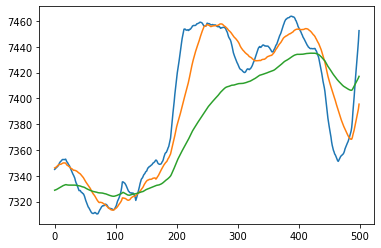

In [13]:
fig = plt.figure()
plt.plot(dataframe_low.SMA_Low[0:500])
plt.plot(dataframe_low.SMA_High[0:500])
plt.plot(dataframe_low.EMA[0:500])
plt.show()

In [14]:
startTimeStamp = dataframe_high.head(1).timestamp.item()
endTimeStamp = dataframe_high.tail(1).timestamp.item()
startTimeStamp,endTimeStamp
dataframe_low = dataframe_low[(dataframe_low.timestamp>=startTimeStamp) 
                              & (endTimeStamp>=dataframe_low.timestamp)]
dataframe_low = dataframe_low.reset_index(drop=True)
dataframe_low

,timestamp,open,high,low,close,volume,close_time,asset_volume,trades,buy_base_asset_volume,...,ignore,SMA_Low,SMA_High,MACD_EMA_Low,MACD_EMA_High,MACD,MACD_Signal,EMA,ATR,EMA_Dev
0,2020-01-08 05:00:00,8343.92,8370.00,8341.79,8367.46,220.284566,1578459899999,1.841392e+06,2238,126.991433,...,0,8313.917727,8341.161273,8322.043466,8298.808062,-23.235404,-25.720423,8129.536842,24.559462,13.522394
1,2020-01-08 05:05:00,8367.57,8377.00,8349.62,8349.63,593.807745,1578460199999,4.968744e+06,2688,308.288824,...,0,8317.047727,8341.586909,8325.427078,8301.027596,-24.399482,-25.310444,8131.839510,24.841515,13.566030
2,2020-01-08 05:10:00,8349.63,8352.45,8335.53,8344.83,201.964015,1578460499999,1.685708e+06,2206,127.412008,...,0,8320.887727,8342.615636,8327.182115,8302.619825,-24.562290,-24.912967,8133.966580,24.049364,13.593118
3,2020-01-08 05:15:00,8345.34,8363.38,8344.46,8355.42,272.685710,1578460799999,2.278570e+06,2163,163.171964,...,0,8325.165909,8343.041636,8329.353235,8304.388759,-24.964476,-24.577882,8136.137559,23.536427,13.595873
4,2020-01-08 05:20:00,8355.43,8361.27,8354.01,8361.27,97.797364,1578461099999,8.173345e+05,1429,72.184158,...,0,8328.455000,8342.396182,8331.843823,8306.303268,-25.540555,-24.316654,8138.345096,21.908785,13.583188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103829,2021-01-03 14:10:00,34048.69,34070.48,33980.44,34048.36,305.252712,1609683299999,1.038270e+07,6019,167.692614,...,0,34102.911818,34098.677818,34077.590773,34088.003737,10.412964,-36.625611,33402.846261,192.122549,51.164788
103830,2021-01-03 14:15:00,34048.35,34111.89,34000.00,34018.13,341.227211,1609683599999,1.162270e+07,6014,191.396651,...,0,34090.470000,34097.811091,34074.721358,34086.453335,11.731978,-30.314922,33409.231796,184.099294,50.000311
103831,2021-01-03 14:20:00,34018.13,34150.00,34018.13,34042.79,338.600072,1609683899999,1.154724e+07,7105,158.557774,...,0,34088.070455,34096.199636,34073.203196,34085.410806,12.207609,-23.666052,33415.679863,178.876365,48.889040
103832,2021-01-03 14:25:00,34042.79,34064.17,33926.96,33926.99,403.285429,1609684199999,1.371424e+07,8839,197.512191,...,0,34077.571818,34093.098364,34065.987918,34082.011402,16.023483,-16.799153,33421.396755,174.709728,47.704594


In [15]:
dataframe_high

,timestamp,open,high,low,close,volume,close_time,asset_volume,trades,buy_base_asset_volume,...,ignore,SMA_Low,SMA_High,MACD_EMA_Low,MACD_EMA_High,MACD,MACD_Signal,EMA,ATR,EMA_Dev
0,2020-01-08 05:00:00,8343.92,8377.00,8312.79,8319.10,1677.474497,1578461399999,1.401637e+07,13435,931.382577,...,0,8205.237727,8011.424000,8205.372047,8029.642141,-175.729906,-154.720683,7643.016997,91.757181,41.625490
1,2020-01-08 05:30:00,8319.11,8360.00,8307.85,8334.77,986.803372,1578463199999,8.222511e+06,9585,401.362183,...,0,8218.741364,8018.747091,8216.246869,8040.384654,-175.862215,-159.552011,7649.856952,87.796463,42.277174
2,2020-01-08 06:00:00,8334.76,8367.61,8320.00,8346.81,904.086030,1578464999999,7.542260e+06,9549,522.657064,...,0,8230.584545,8026.940000,8227.207576,8051.167166,-176.040410,-164.157862,7656.746883,83.777817,42.893683
3,2020-01-08 06:30:00,8346.93,8349.58,8319.00,8339.13,827.857424,1578466799999,6.897744e+06,9030,365.314050,...,0,8242.650000,8034.973091,8236.899091,8061.434767,-175.464324,-168.071156,7663.532088,78.458035,43.468322
4,2020-01-08 07:00:00,8339.14,8347.99,8320.01,8330.68,844.495811,1578468599999,7.037641e+06,9413,437.842795,...,0,8252.770455,8042.896364,8245.382214,8071.185490,-174.196724,-170.827102,7670.207938,73.410231,43.981448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17303,2021-01-03 12:30:00,34293.53,34354.53,33928.75,34103.72,1997.305209,1609678799999,6.813059e+07,40391,918.918794,...,0,33744.101364,32476.400909,33679.366143,32583.939129,-1095.427013,-1112.840214,30232.894603,539.614825,264.127707
17304,2021-01-03 13:00:00,34103.73,34385.02,34100.73,34162.14,1384.629374,1609680599999,4.741955e+07,32238,692.046710,...,0,33806.795909,32559.114909,33723.586913,32641.223625,-1082.363288,-1117.710273,30272.247940,514.082342,266.254301
17305,2021-01-03 13:30:00,34164.10,34193.66,33800.00,33880.00,2989.109002,1609682399999,1.016119e+08,55719,1358.514091,...,0,33858.538182,32633.660727,33748.443703,32690.088495,-1058.355208,-1117.816616,30309.433931,502.040108,267.723317
17306,2021-01-03 14:00:00,33877.98,34150.00,33641.02,33926.99,2550.922734,1609684199999,8.668146e+07,50012,1194.770772,...,0,33916.779545,32710.860727,33761.535338,32733.263817,-1028.271521,-1112.336768,30345.150982,502.734097,268.301797


In [23]:
sma_strategy = SMAStrategy(dataframe_high,dataframe_low)

back = Backtest(
    10000,
    1000,
    3,
    0.075/100,
    'BTCUSDT',
    sma_strategy,
    dataframe_low)
current_balance,balance_list,order_details = back.runBacktest()
# cap_returns = round((current_balance -starting_capital) *100/current_balance)

fig = plt.figure()
# plt.plot(dataframe_low.loc[0:10000].close)
plt.plot(balance_list)
plt.show()
order_details
order_details.to_csv('./data/SMA/OrderDetails.csv',index=False)
# balance_list

KeyboardInterrupt: 

In [17]:
order_details

,count,open_time,close_time,trade_duration,order_type,balance_prior,balance_post,total_pnl,price_symbol,quantity_symbol,squareOff_price_symbol,order_pnl,pnl_percentage
0,1,2020-01-08 05:00:00,2020-01-08 13:05:00,0 days 08:05:00,OrderStatus.LONG,10000,9572.554416,-427.445584,8367.46,3.582628,8260.71,-427.445584,-4
1,2,2020-01-08 13:10:00,2020-01-09 20:50:00,1 days 07:40:00,OrderStatus.LONG,9572.55,7964.709375,-2035.290625,8266.44,3.471401,7815.68,-1607.845042,-17
2,3,2020-01-10 14:00:00,2020-01-11 21:50:00,1 days 07:50:00,OrderStatus.LONG,7964.71,8581.778680,-1418.221320,7859.75,3.037782,8074.68,617.069305,8
3,4,2020-01-14 01:15:00,2020-01-19 11:00:00,5 days 09:45:00,OrderStatus.LONG,8581.78,9614.409318,-385.590682,8345.93,3.082464,8693.46,1032.630638,12
4,5,2020-01-21 22:15:00,2020-01-22 08:35:00,0 days 10:20:00,OrderStatus.LONG,9614.41,9472.124604,-527.875396,8714.60,3.307277,8684.66,-142.284713,-1
5,6,2020-01-26 17:30:00,2020-01-27 08:45:00,0 days 15:15:00,OrderStatus.LONG,9472.12,9512.846369,-487.153631,8561.48,3.316607,8586.61,40.721764,0
6,7,2020-01-27 14:00:00,2020-01-28 15:35:00,1 days 01:35:00,OrderStatus.LONG,9512.85,10238.709439,238.709439,8744.30,3.261226,8980.00,725.863070,8
7,8,2020-01-28 23:25:00,2020-01-30 16:30:00,1 days 17:05:00,OrderStatus.LONG,10238.7,10656.718730,656.718730,9152.70,3.353447,9291.09,418.009290,4
8,9,2020-01-30 18:05:00,2020-01-31 10:45:00,0 days 16:40:00,OrderStatus.LONG,10656.7,9994.397751,-5.602249,9506.39,3.360495,9323.57,-662.320978,-6
9,10,2020-02-01 03:20:00,2020-02-01 22:35:00,0 days 19:15:00,OrderStatus.LONG,9994.4,9729.341306,-270.658694,9423.23,3.179452,9354.01,-265.056445,-3


In [18]:
order_details.iloc[0].close_time

'2020-01-08 13:05:00'

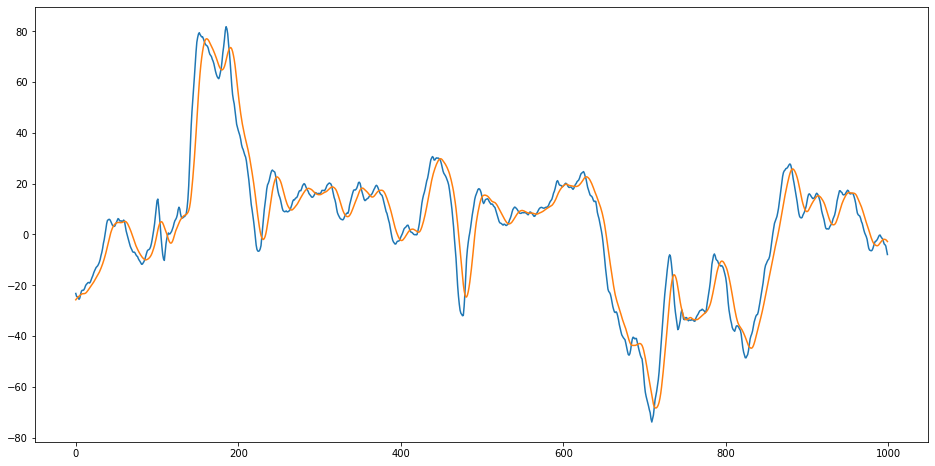

In [19]:
len_p = 1000
fig = plt.figure(figsize=(16,8))
# plt.plot(dataframe_low.SMA_Low[0:len_p])
# plt.plot(dataframe_low.SMA_High[0:len_p])
# plt.plot(dataframe_low.EMA[0:len_p])

plt.plot(dataframe_low.MACD[0:len_p])
plt.plot(dataframe_low.MACD_Signal[0:len_p])
plt.show()

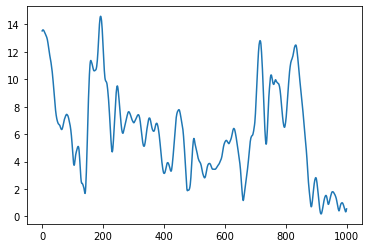

In [20]:
plt.plot(dataframe_low.EMA_Dev[0:len_p])

In [21]:
max_loss = order_details.pnl_percentage.min()
max_profit = order_details.pnl_percentage.max()

<StemContainer object of 3 artists>

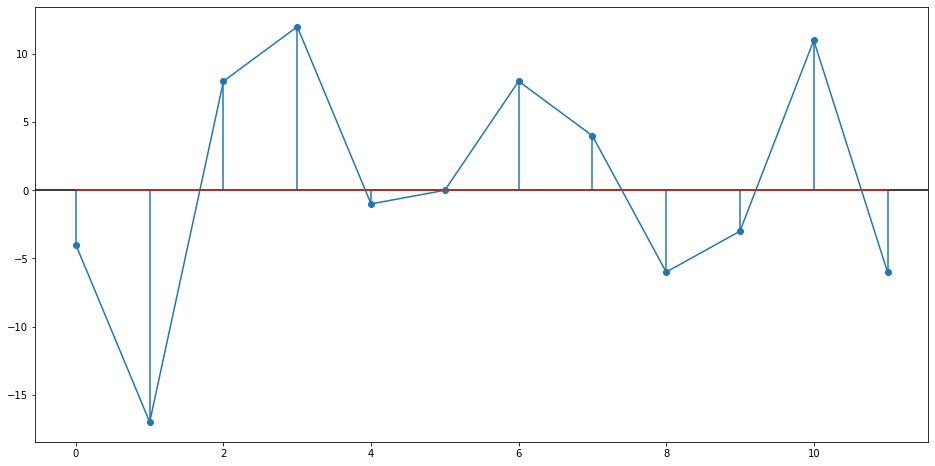

In [22]:
plt.figure(figsize=(16,8))
plt.axhline(0,c="black")
# plt.axhline(max_loss,c="salmon")
# plt.axhline(max_profit,c="salmon")
# plt.text(y=max_loss, x=0, s=('Max Loss : ' + str(max_loss)))
# plt.text(y=max_profit, x=0, s=('Max Profit : ' + str(max_profit)))
plt.plot(order_details.pnl_percentage)
plt.stem(order_details.pnl_percentage,use_line_collection=True)